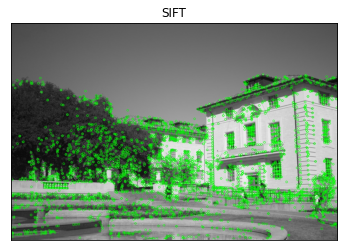

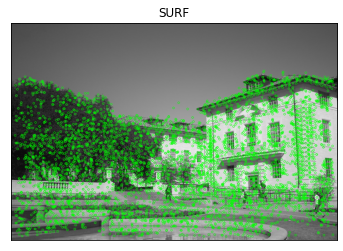

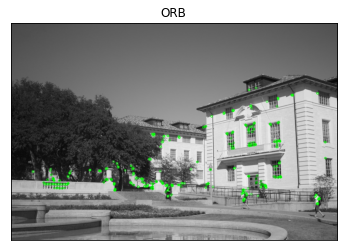

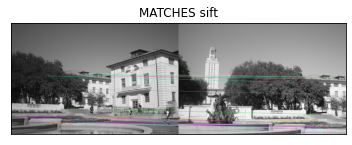

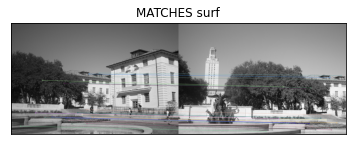

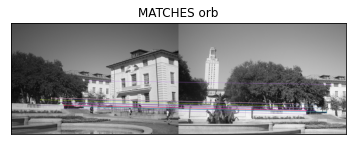

[[ 7.53676173e-01  3.20608754e-02  4.49403859e+02]
 [-1.37243188e-01  9.03515969e-01  7.78782391e+01]
 [-2.16548891e-04 -3.93161066e-05  1.00000000e+00]]
[[ 7.56576750e-01  4.40391571e-02  4.46374446e+02]
 [-1.39242870e-01  9.13560431e-01  7.64410862e+01]
 [-2.19170189e-04 -2.77753674e-05  1.00000000e+00]]
[[ 8.07211601e-01  8.82750926e-02  4.30902634e+02]
 [-1.27715852e-01  9.69709736e-01  6.08550934e+01]
 [-1.98220229e-04  1.89427688e-05  1.00000000e+00]]


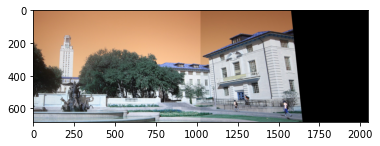

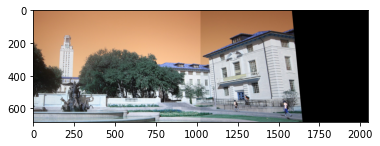

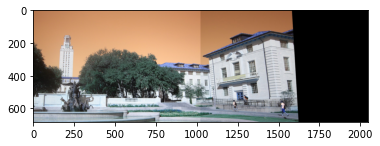

In [1]:
"""
TRABALHO 5 DE MC920

Aluno: Miguel Augusto Silva Guida    RA: 174847

"""


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lendo as imagens

imgA = cv2.imread('foto1A.jpg', cv2.IMREAD_GRAYSCALE)
colorA = cv2.imread('foto1A.jpg')

imgB = cv2.imread('foto1B.jpg', cv2.IMREAD_GRAYSCALE)
colorB = cv2.imread('foto1B.jpg')


# Obtendo Pontos de Interesse e Descritores para as imagens

# SIFT
sift = cv2.xfeatures2d.SIFT_create()
kp_siftA, desc_siftA = sift.detectAndCompute(imgA,None)
kp_siftB, desc_siftB = sift.detectAndCompute(imgB,None)

img=cv2.drawKeypoints(imgA,kp_siftA, None, color=(0,255,0), flags=0)
cv2.imwrite('sift_keypointsA.jpg',img)
plt.imshow(img), plt.title('SIFT'), plt.xticks([]), plt.yticks([]), plt.show()

img=cv2.drawKeypoints(imgB,kp_siftB, None, color=(0,255,0), flags=0)
cv2.imwrite('sift_keypointsB.jpg',img)


# SURF
surf = cv2.xfeatures2d.SURF_create()
kp_surfA, desc_surfA = surf.detectAndCompute(imgA,None)
kp_surfB, desc_surfB = surf.detectAndCompute(imgB,None)

img=cv2.drawKeypoints(imgA,kp_surfA, None, color=(0,255,0), flags=0)
cv2.imwrite('surf_keypointsA.jpg',img)
plt.imshow(img), plt.title('SURF'), plt.xticks([]), plt.yticks([]), plt.show()

img=cv2.drawKeypoints(imgB,kp_surfB, None, color=(0,255,0), flags=0)
cv2.imwrite('surf_keypointsB.jpg',img)



# ORB
orb = cv2.ORB_create()

kp_orbA = orb.detect(imgA,None)
kp_orbA, desc_orbA = orb.compute(imgA, kp_orbA)

kp_orbB = orb.detect(imgB,None)
kp_orbB, desc_orbB = orb.compute(imgB, kp_orbB)


img = cv2.drawKeypoints(imgA, kp_orbA, None, color=(0,255,0), flags=0)
cv2.imwrite('orb_keypointsA.jpg',img)
plt.imshow(img), plt.title('ORB'), plt.xticks([]), plt.yticks([]), plt.show()


img = cv2.drawKeypoints(imgB, kp_orbB, None, color=(0,255,0), flags=0)
cv2.imwrite('orb_keypointsB.jpg',img)


# Funcao para computar as distancias dos descritores e ordenar pela menor distancia
def computarDistancias(algorithm, descA, descB):
    if algorithm == 'sift' or  algorithm == 'surf': 
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(descA,descB)
        matches = sorted(matches, key = lambda x:x.distance)
        return matches

    if algorithm == 'orb': 
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descA,descB)
        matches = sorted(matches, key = lambda x:x.distance)
        return matches

matches_sift = computarDistancias('sift', desc_siftA, desc_siftB)
matches_surf = computarDistancias('surf', desc_surfA, desc_surfB)
matches_orb = computarDistancias('orb', desc_orbA, desc_orbB)


# Funcao para exibir os 20 melhores matches encontrados
def mostraMatches(alg, imgA, kpA, imgB, kpB, matches):
    img = imgA
    img = cv2.drawMatches(imgA,kpA,imgB,kpB,matches[:20], img, flags=2)
    cv2.imwrite('matches_'+alg+'.jpg',img)
    plt.imshow(img), plt.title('MATCHES ' + alg), plt.xticks([]), plt.yticks([]), plt.show()
    
mostraMatches('sift', imgA, kp_siftA, imgB, kp_siftB, matches_sift)
mostraMatches('surf', imgA, kp_surfA, imgB, kp_surfB, matches_surf)
mostraMatches('orb', imgA, kp_orbA, imgB, kp_orbB, matches_orb)


# Funcao para calcular a matriz de homografia dados pontos de interesse e matches.
def encontraMatrizDeHomografia(kpA, kpB, matches):
    src_pts = np.float32([ kpA[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpB[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    return M

M_sift = encontraMatrizDeHomografia(kp_siftA, kp_siftB, matches_sift[:40])
M_surf = encontraMatrizDeHomografia(kp_surfA, kp_surfB, matches_surf[:40])
M_orb = encontraMatrizDeHomografia(kp_orbA, kp_orbB, matches_orb[:30])

print(M_sift)
print(M_surf)
print(M_orb)

# Funcao para juntar duas imagens
def juntarImagens(alg, imgA, imgB, M):
    dst = cv2.warpPerspective(imgA,M,((imgA.shape[1] + imgB.shape[1]), imgB.shape[0]))
    dst[0:imgB.shape[0], 0:imgB.shape[1]] = imgB
    cv2.imwrite('output_'+alg+'.jpg',dst)
    plt.imshow(dst), plt.show()
    
juntarImagens('sift', colorA, colorB, M_sift)
juntarImagens('surf', colorA, colorB, M_surf)
juntarImagens('orb', colorA, colorB, M_orb)

